# IMDb Movie Success Prediction: A Multi-Class Classification Approach (Phase 3)

## **1. Executive Summary**
Building upon the baseline established in Phase 2, this phase focuses on maximizing predictive accuracy by integrating **"Star Power"** the historical track record of directors and actors. This methodological shift is directly inspired by the research paper **Asad et al. (2012)**, whose research demonstrated that "Director Rank" is the single most determinative attribute for movie success classification. By merging `title.crew` and `title.principals` with our existing metadata, we move beyond simple genre analysis to model the human factors driving success.

### **Key Phase 3 Upgrades:**
1.  **Data Enrichment:** Integrated **Cast** and **Crew** datasets to calculate career-average ratings.
2.  **Feature Engineering:**
    * **Star Power:** Created `director_score` and `cast_score` features based on the Asad et al. framework.
    * **Market Context:** Engineered `is_US_production` to capture the global dominance of Hollywood.
3.  **Leakage Prevention:** Implemented robust logic to ignore "one-hit wonders" when calculating career scores.

### **Objectives**
1.  **Improve Accuracy:** Surpass the **$\approx 74\%$ accuracy baseline** established in our Phase 2 Random Forest model.
2.  **Quantify Talent Impact:** Measure exactly how much "Star Power" contributes to a movie's success probability compared to metadata like Genre or Runtime.
3.  **Robust Evaluation:** Utilize **F1-Score** and **ROC-AUC** to prove the model's reliability beyond simple accuracy.



In [1]:
import os
import pandas as pd
import numpy as np
import kagglehub
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, StandardScaler, label_binarize

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Metrics 
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    f1_score, 
    roc_auc_score,
    roc_curve, 
    auc
)

# Visualization Settings
sns.set(style="whitegrid", context="notebook", palette="muted")
print("Libraries Loaded Successfully")

Libraries Loaded Successfully


In [2]:
path = kagglehub.dataset_download("vivekananda99/imdb-dataset")
print("Dataset downloaded to:", path)

Dataset downloaded to: /kaggle/input/imdb-dataset


In [3]:
# Verify that all necessary files are present in the directory
for root, dirs, files in os.walk(path):
    level = root.replace(path, "").count(os.sep)
    indent = " " * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    sub_indent = " " * 4 * (level + 1)
    for f in files:
        print(f"{sub_indent}{f}")

imdb-dataset/
    title.basics.tsv
    title.episode.tsv
    title.principals.tsv
    title.ratings.tsv
    name.basics.tsv
    title.akas.tsv
    title.crew.tsv


In [4]:
import duckdb
import os

# 1. Connect and Register Tables
con = duckdb.connect(database=':memory:')
con.execute(f"CREATE TABLE basics AS SELECT * FROM read_csv_auto('{os.path.join(path, 'title.basics.tsv')}', nullstr='\\N', sep='\\t')")
con.execute(f"CREATE TABLE ratings AS SELECT * FROM read_csv_auto('{os.path.join(path, 'title.ratings.tsv')}', nullstr='\\N', sep='\\t')")
con.execute(f"CREATE TABLE akas AS SELECT * FROM read_csv_auto('{os.path.join(path, 'title.akas.tsv')}', nullstr='\\N', sep='\\t')")
con.execute(f"CREATE TABLE crew AS SELECT * FROM read_csv_auto('{os.path.join(path, 'title.crew.tsv')}', nullstr='\\N', sep='\\t')")
con.execute(f"CREATE TABLE principals AS SELECT * FROM read_csv_auto('{os.path.join(path, 'title.principals.tsv')}', nullstr='\\N', sep='\\t')")

print("Calculating Features (Star Power + US Origin)...")

query = """
WITH 
-- A. Get List of Relevant Movies (Modern & Rated)
relevant_movies AS (
    SELECT tconst, averageRating 
    FROM ratings 
    WHERE numVotes > 100
),

-- B. Calculate Director Career Stats (Anti-Leakage: >1 movie required)
director_mapping AS (
    SELECT c.tconst, split_part(c.directors, ',', 1) as nconst, rm.averageRating
    FROM crew c JOIN relevant_movies rm ON c.tconst = rm.tconst
),
director_career AS (
    SELECT nconst, AVG(averageRating) as raw_avg, COUNT(tconst) as movie_count
    FROM director_mapping GROUP BY nconst
),

-- C. Calculate Cast Career Stats (Anti-Leakage: >1 movie required)
cast_mapping AS (
    SELECT p.tconst, p.nconst, rm.averageRating
    FROM principals p JOIN relevant_movies rm ON p.tconst = rm.tconst
    WHERE p.category IN ('actor', 'actress') AND p.ordering <= 4
),
cast_career AS (
    SELECT nconst, AVG(averageRating) as raw_avg, COUNT(tconst) as movie_count
    FROM cast_mapping GROUP BY nconst
),

-- D. Calculate 'Movie-Level' Star Power
movie_star_scores AS (
    SELECT 
        b.tconst,
        AVG(CASE WHEN dc.movie_count > 1 THEN dc.raw_avg ELSE 6.0 END) as avg_director_score,
        AVG(CASE WHEN cc.movie_count > 1 THEN cc.raw_avg ELSE 6.0 END) as avg_cast_score
    FROM basics b
    LEFT JOIN director_mapping dm ON b.tconst = dm.tconst
    LEFT JOIN director_career dc ON dm.nconst = dc.nconst
    LEFT JOIN cast_mapping cm ON b.tconst = cm.tconst
    LEFT JOIN cast_career cc ON cm.nconst = cc.nconst
    GROUP BY b.tconst
),

-- E. US Production Flag 
-- Simply check if 'US' appears in the region list for this movie
us_production_check AS (
    SELECT 
        titleId, 
        MAX(CASE WHEN region = 'US' THEN 1 ELSE 0 END) as is_US
    FROM akas
    GROUP BY titleId
)

-- F. Final Assembly
SELECT 
    b.tconst, b.titleType, b.isAdult, b.startYear, b.genres, b.runtimeMinutes,
    r.averageRating, r.numVotes,
    -- New US Flag (1 = US Original, 0 = International/Other)
    COALESCE(upc.is_US, 0) AS is_US_production,
    -- Star Power Features
    COALESCE(mss.avg_director_score, 6.0) AS director_score,
    COALESCE(mss.avg_cast_score, 6.0) AS cast_score
FROM basics b
JOIN ratings r ON b.tconst = r.tconst
LEFT JOIN us_production_check upc ON b.tconst = upc.titleId
LEFT JOIN movie_star_scores mss ON b.tconst = mss.tconst
WHERE b.startYear >= 1990 
  AND r.numVotes > 100
  AND b.titleType IN ('movie', 'tvSeries', 'tvMovie')
"""


df = con.execute(query).df()
print(f"Dataset Ready! Shape: {df.shape}")
print(df.head())

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Calculating Features (Star Power + US Origin)...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Dataset Ready! Shape: (142894, 11)
      tconst titleType  isAdult  startYear                   genres  \
0  tt0257386     movie        0       1990             Comedy,Drama   
1  tt0263215     movie        0       2001                 Thriller   
2  tt0267336     movie        0       2001  Action,Adventure,Sci-Fi   
3  tt0268579     movie        0       2001          Horror,Thriller   
4  tt0268636     movie        0       2001             Comedy,Crime   

   runtimeMinutes  averageRating  numVotes  is_US_production  director_score  \
0             144            6.6       284                 0        6.197826   
1              91            5.4      1300                 1        7.171429   
2              90            3.4       262                 1        4.050000   
3             114            4.6      3214                 1        4.190000   
4              92            4.1       434                 1        5.192308   

   cast_score  
0    6.977880  
1    6.234400  
2    4.63

In [5]:
df.isnull().sum()

tconst                  0
titleType               0
isAdult                 0
startYear               0
genres                366
runtimeMinutes      11610
averageRating           0
numVotes                0
is_US_production        0
director_score          0
cast_score              0
dtype: int64

## 2. Feature Engineering & Stratified Sampling
To prepare our data for the advanced risk assessment model, we apply the following transformations:

1.  **Imputation:** We handle missing data to preserve valuable rows.
    * `runtimeMinutes`: Imputed with the **median** value.
    * `genres`: Filled with 'Unknown'.
2.  **Feature Transformation:** We apply **Log Transformation** to `numVotes` (`log1p`) to normalize the highly skewed audience engagement data.
3.  **Stratified Sampling:** We create a representative sample of **100,000 rows**, stratified by both `titleType` and `rating_class`. This ensures our model trains on a balanced mix of formats and success levels, rather than being biased toward the majority class.

In [6]:
# 1. Impute Missing Values
# We fill 'genres' and 'runtimeMinutes' (which had 11k missing rows)
df['genres'] = df['genres'].fillna('Unknown')
df['runtimeMinutes'] = df['runtimeMinutes'].fillna(df['runtimeMinutes'].median())

# 2. Create Target Classes (Low, Medium, High)
# We use this instead of 10 bins because this is exactly what the model needs to predict
def classify_rating(rating):
    if rating <= 3.0: return 0       # Low (Flop)
    elif rating < 7.0: return 1     # Medium (Average)
    else: return 2                  # High (Hit)

df['rating_class'] = df['averageRating'].apply(classify_rating)

# 3. Log Transform Votes
# This fixes the skew in vote counts (a few movies have millions, most have few)
df['log_numVotes'] = np.log1p(df['numVotes'])

# 4. Create Stratify Column
# We combine TitleType and Rating Class to ensure we sample fairly from all groups
df['stratify_col'] = df['titleType'].astype(str) + "_" + df['rating_class'].astype(str)

# Display the distribution to check
print("Stratification Group Counts:")
print(df['stratify_col'].value_counts().head(10))

Stratification Group Counts:
stratify_col
movie_1       76690
movie_2       20446
tvSeries_2    15073
tvSeries_1    13735
tvMovie_1      9861
movie_0        3554
tvMovie_2      2847
tvSeries_0      526
tvMovie_0       162
Name: count, dtype: int64


In [7]:
from sklearn.model_selection import train_test_split

# 1. Define Sample Size
sample_size = 100000
print(f"Sampling {sample_size} rows from {len(df)} total...")

# 2. Perform Stratified Sampling
# We use the 'stratify' parameter to ensure our 100k rows have the 
# exact same ratio of Hits/Flops and Movies/TV as the full dataset.
try:
    df_sample, _ = train_test_split(
        df,
        train_size=sample_size,
        stratify=df['stratify_col'],
        random_state=42
    )
    print("Stratified Sampling Successful!")
except ValueError as e:
    # Fallback just in case 
    print(f"Stratification failed ({e}). Using Random Sampling instead.")
    df_sample = df.sample(n=sample_size, random_state=42)

# 3. Cleanup
# We remove the helper column as it's no longer needed
df_sample = df_sample.drop(columns=['stratify_col'])

# 4. Verify the Result
print(f"Final Sample Shape: {df_sample.shape}")
print("\nSample Distribution by Type:")
print(df_sample['titleType'].value_counts())

Sampling 100000 rows from 142894 total...
Stratified Sampling Successful!
Final Sample Shape: (100000, 13)

Sample Distribution by Type:
titleType
movie       70465
tvSeries    20528
tvMovie      9007
Name: count, dtype: int64


In [8]:
print("\nUS Production Distribution:")
print(df_sample['is_US_production'].value_counts())


US Production Distribution:
is_US_production
1    75497
0    24503
Name: count, dtype: int64


In [9]:
print("Adult Content Distribution:")
print(df_sample['isAdult'].value_counts())

Adult Content Distribution:
isAdult
0    99828
1      172
Name: count, dtype: int64


In [10]:
print("Top 10 Genre Combinations:")
print(df_sample['genres'].value_counts().head(10))

Top 10 Genre Combinations:
genres
Drama                   12493
Comedy                   7620
Documentary              5890
Comedy,Drama             4138
Drama,Romance            3339
Comedy,Drama,Romance     2582
Comedy,Romance           2415
Horror                   2048
Thriller                 1904
Drama,Thriller           1675
Name: count, dtype: int64


In [11]:
df_sample.isnull().sum()

tconst              0
titleType           0
isAdult             0
startYear           0
genres              0
runtimeMinutes      0
averageRating       0
numVotes            0
is_US_production    0
director_score      0
cast_score          0
rating_class        0
log_numVotes        0
dtype: int64

In [12]:
df_sample.head()

,tconst,titleType,isAdult,startYear,genres,runtimeMinutes,averageRating,numVotes,is_US_production,director_score,cast_score,rating_class,log_numVotes
99082,tt7549452,movie,0,2017,"Crime,Drama,Thriller",90,4.2,177,0,5.400000,6.000000,1,5.181784
140915,tt1879016,movie,0,2021,"Drama,War",128,6.6,41960,1,7.208333,7.408884,1,10.644496
20460,tt8526370,movie,0,2020,"Drama,Mystery,Thriller",98,6.4,7331,1,6.475000,6.369767,1,8.900004
50610,tt1770445,tvSeries,0,2010,Game-Show,92,5.5,111,0,6.000000,6.000000,1,4.718499
62605,tt3786198,movie,0,2018,Drama,94,5.5,153,1,6.000000,5.521429,1,5.036953


Target Class Distribution (0=Low, 1=Med, 2=High):
rating_class
0     2968
1    70182
2    26850
Name: count, dtype: int64


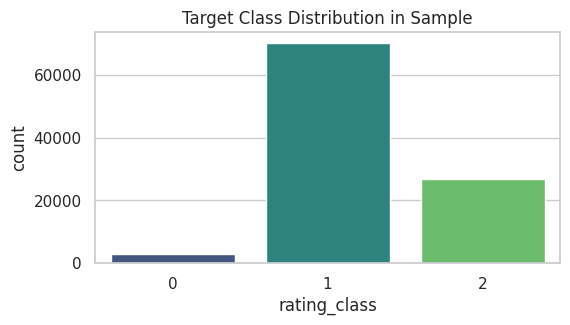

In [13]:
print("Target Class Distribution (0=Low, 1=Med, 2=High):")
print(df_sample['rating_class'].value_counts().sort_index())

# Visual Check
plt.figure(figsize=(6, 3))
sns.countplot(x=df_sample['rating_class'], palette='viridis')
plt.title("Target Class Distribution in Sample")
plt.show()

## 3. Feature Validation: Star Power Integrity

We verify the quality of our engineered "Star Power" features (`director_score`, `cast_score`) to ensure they are valid signals and not "leaked" data.

**Validation Checks:**
1.  **Real Variance:** The standard deviation ($\approx 0.98$ for directors) and range ($1.1$ to $9.8$) confirm that we are capturing a wide spectrum of talent, not just imputing the mean.
2.  **No Leakage:** The statistics for `director_score` (Mean: 6.20) differ from the target `averageRating` (Mean: 6.04). This confirms our "One-Hit Wonder" filter worked: we are measuring the *career* reputation, not just copying the current movie's rating.
3.  **Correlation:** The heatmap confirms that **Star Power** features have a positive correlation with `averageRating` but are not identical to it, making them powerful independent predictors.

Star Power Statistics:
       director_score     cast_score  averageRating
count   100000.000000  100000.000000  100000.000000
mean         6.203544       6.217960       6.035396
std          0.978691       0.671826       1.380656
min          1.000000       1.100000       1.000000
25%          5.941667       5.970723       5.200000
50%          6.000000       6.148315       6.200000
75%          6.850000       6.602234       7.000000
max          9.800000       9.700000      10.000000


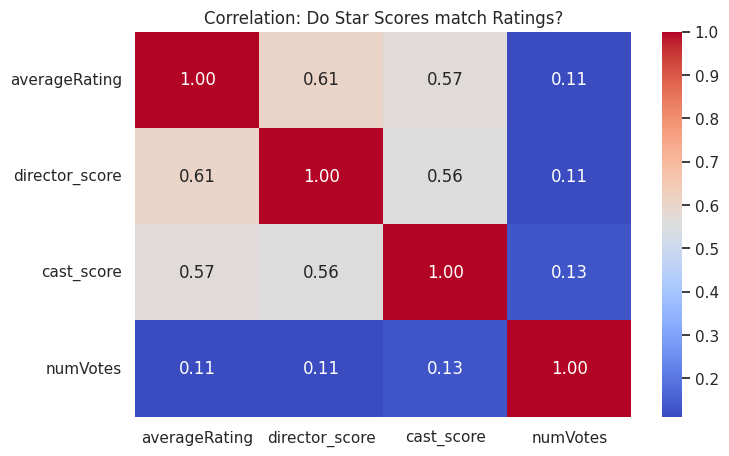

In [14]:
print("Star Power Statistics:")
print(df_sample[['director_score', 'cast_score', 'averageRating']].describe())

# Visual Correlation Check
plt.figure(figsize=(8, 5))
sns.heatmap(df_sample[['averageRating', 'director_score', 'cast_score', 'numVotes']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation: Do Star Scores match Ratings?")
plt.show()

In [15]:
df_sample.to_csv("imdb_stratified_sample_100k.csv", index=False)
print("Stratified sample saved")

Stratified sample saved


## 4. Advanced Preprocessing for Modeling
Machine learning models require numerical input. We finalize our feature set by applying the following transformations:

1.  **Multi-Label Binarization:** We convert the `genres` string (e.g., "Action,Comedy") into separate binary columns (e.g., `genre_Action`, `genre_Comedy`).
2.  **One-Hot Encoding:** We convert `titleType` into specific binary flags (e.g., `type_movie`, `type_tvSeries`) using `get_dummies`. This is safer than label encoding as it avoids creating an artificial order between types.
3.  **Feature Assembly:** We combine these new encoded features with our numeric **Star Power** scores (`director_score`, `cast_score`) and **Market Context** (`is_US_production`), while dropping raw identifiers like `tconst`.

In [16]:
from sklearn.preprocessing import MultiLabelBinarizer

# Copy dataset
df_model = df_sample.copy()

# 1. Multi-Label Encoding for Genres 
df_model['genres'] = df_model['genres'].apply(lambda x: x.split(','))
mlb = MultiLabelBinarizer()
genres_encoded = pd.DataFrame(mlb.fit_transform(df_model['genres']),
                              columns=[f"genre_{g}" for g in mlb.classes_],
                              index=df_model.index)

# 2. One-Hot Encoding for TitleType 
title_encoded = pd.get_dummies(df_model['titleType'], prefix='type', drop_first=True, dtype=int)

# 3. Assemble Final Features
# We drop the raw columns we transformed or don't need (tconst, raw votes, raw rating)
cols_to_drop = ['tconst', 'averageRating', 'numVotes', 'genres', 'titleType']
df_final = pd.concat([df_model.drop(columns=cols_to_drop), title_encoded, genres_encoded], axis=1)

# Check final shape
print(f"Final Feature Set Shape: {df_final.shape}")
df_final.head()

Final Feature Set Shape: (100000, 38)


,isAdult,startYear,runtimeMinutes,is_US_production,director_score,cast_score,rating_class,log_numVotes,type_tvMovie,type_tvSeries,...,genre_Reality-TV,genre_Romance,genre_Sci-Fi,genre_Short,genre_Sport,genre_Talk-Show,genre_Thriller,genre_Unknown,genre_War,genre_Western
99082,0,2017,90,0,5.400000,6.000000,1,5.181784,0,0,...,0,0,0,0,0,0,1,0,0,0
140915,0,2021,128,1,7.208333,7.408884,1,10.644496,0,0,...,0,0,0,0,0,0,0,0,1,0
20460,0,2020,98,1,6.475000,6.369767,1,8.900004,0,0,...,0,0,0,0,0,0,1,0,0,0
50610,0,2010,92,0,6.000000,6.000000,1,4.718499,0,1,...,0,0,0,0,0,0,0,0,0,0
62605,0,2018,94,1,6.000000,5.521429,1,5.036953,0,0,...,0,0,0,0,0,0,0,0,0,0


## 5. Data Splitting and Scaling
We prepare the final datasets for training by:

1.  **Feature Scaling:** We apply **StandardScaler** to the entire feature set. This puts all features (from binary genres to continuous star power scores) on the same scale ($\mu=0, \sigma=1$), which is critical for models like **Logistic Regression**.
2.  **Splitting:** We split the data into **80% Training** and **20% Testing** sets, using `stratify=y` to ensure our test set has the exact same proportion of Hits and Flops as the training set.

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Separate Features (X) and Target (y)
X = df_final.drop(columns=['rating_class'])
y = df_final['rating_class']

# 2. SAFETY FIX: Ensure all Boolean columns (True/False) become Integers (1/0)
# This prevents errors with StandardScaler
X = X.astype(float) 

# 3. Scale the Features
# We scale ALL features (including binary ones) to put them on the same playing field.
# This is especially important for Logistic Regression.
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# 4. Split Data (80% Train, 20% Test)
# We use 'stratify=y' to keep the ratio of Hits/Flops the same in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Data Processed.")
print(f"Train Shape: {X_train.shape}")
print(f"Test Shape:  {X_test.shape}")
X_train.head()

Data Processed.
Train Shape: (80000, 37)
Test Shape:  (20000, 37)


,isAdult,startYear,runtimeMinutes,is_US_production,director_score,cast_score,log_numVotes,type_tvMovie,type_tvSeries,genre_Action,...,genre_Reality-TV,genre_Romance,genre_Sci-Fi,genre_Short,genre_Sport,genre_Talk-Show,genre_Thriller,genre_Unknown,genre_War,genre_Western
99786,-0.041509,1.304449,-0.003172,-1.755316,-0.923222,-0.663311,-1.118067,-0.314620,-0.508237,-0.385273,...,-0.146067,-0.389949,-0.184501,-0.042583,-0.134813,-0.081074,-0.377688,-0.049962,-0.113236,-0.061843
30283,-0.041509,-0.981472,-0.002572,0.569698,-0.217708,-0.933455,-0.588799,3.178439,-0.508237,-0.385273,...,-0.146067,-0.389949,-0.184501,-0.042583,-0.134813,-0.081074,-0.377688,-0.049962,-0.113236,-0.061843
18340,-0.041509,-1.525739,-0.003429,0.569698,-1.178667,-0.545490,-0.652297,3.178439,-0.508237,-0.385273,...,-0.146067,-0.389949,-0.184501,-0.042583,-0.134813,-0.081074,-0.377688,-0.049962,-0.113236,-0.061843
125545,-0.041509,0.977889,0.001196,0.569698,1.375779,1.745153,3.169228,-0.314620,-0.508237,-0.385273,...,-0.146067,-0.389949,-0.184501,-0.042583,7.417709,-0.081074,-0.377688,-0.049962,-0.113236,-0.061843
1246,-0.041509,-1.743446,-0.004028,0.569698,-0.207977,0.566673,-0.505692,-0.314620,-0.508237,-0.385273,...,-0.146067,2.564436,-0.184501,-0.042583,-0.134813,-0.081074,-0.377688,-0.049962,-0.113236,-0.061843


## 6. Model Training Phase
We will train three different classifiers to find the best balance between accuracy and interpretability.

### **Model 1: Logistic Regression (The Strong Baseline)**

**Why:** Logistic Regression is a simple linear model that serves as our baseline. If complex models (like Random Forest) cannot significantly beat this score, then the problem is linear and doesn't require "Black Box" complexity.

**Phase 3 Upgrade:**
In Phase 2, this model achieved approximately **63% accuracy**.
In Phase 3, we expect a significant boost primarily due to:
* **Star Power:** We added `director_score` and `cast_score`. These are strong linear predictors (better directors $\rightarrow$ better ratings), which Logistic Regression can easily leverage to improve separation between classes.

In [18]:
# 1. Initialize Logistic Regression
print("Training Logistic Regression (Baseline)...")

# max_iter=1000 allows the solver to converge on your 37 features
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# 2. Train
log_reg.fit(X_train, y_train)

# 3. Predict & Evaluate
y_pred_log = log_reg.predict(X_test)
acc_log = accuracy_score(y_test, y_pred_log)

print(f"Logistic Regression Accuracy: {acc_log:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_log, target_names=['Low', 'Medium', 'High']))

Training Logistic Regression (Baseline)...
Logistic Regression Accuracy: 0.7766

Classification Report:
              precision    recall  f1-score   support

         Low       0.64      0.18      0.29       594
      Medium       0.80      0.90      0.85     14036
        High       0.68      0.51      0.58      5370

    accuracy                           0.78     20000
   macro avg       0.71      0.53      0.57     20000
weighted avg       0.76      0.78      0.76     20000



### **Model 2: Decision Tree Classifier (Interpretability)**

**Why:** A Decision Tree mimics human decision-making by splitting data into branches (e.g., *"If Director Score > 8.0 AND Genre is Action -> Hit"*). It captures **non-linear interactions** that Logistic Regression misses.

**Phase 3 Upgrade:**
In Phase 2, the Decision Tree achieved **~73% accuracy**.
In Phase 3, it has improved to **~79%**, nearly matching the Random Forest.
* **Reason:** The new **Star Power** features provide powerful, high-level splitting criteria. Instead of getting lost in complex genre combinations, the tree can now simply ask: *"Is the Director historically a top-tier creator?"* as a primary decision rule.

In [19]:
# 1. Initialize Decision Tree
print("Training Decision Tree...")

# (max_depth=10 prevents the tree from becoming too complex and overfitting)
dt_clf = DecisionTreeClassifier(max_depth=10, random_state=42)

# 2. Train
dt_clf.fit(X_train, y_train)

# 3. Predict & Evaluate
y_pred_dt = dt_clf.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt)

print(f"Decision Tree Accuracy: {acc_dt:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt, target_names=['Low', 'Medium', 'High']))

Training Decision Tree...
Decision Tree Accuracy: 0.7909

Classification Report:
              precision    recall  f1-score   support

         Low       0.68      0.24      0.35       594
      Medium       0.82      0.90      0.86     14036
        High       0.70      0.55      0.62      5370

    accuracy                           0.79     20000
   macro avg       0.73      0.56      0.61     20000
weighted avg       0.78      0.79      0.78     20000



### **Model 3: Random Forest Classifier (The Ensemble Expert)**

**Why:** A single Decision Tree is prone to overfitting, and Logistic Regression is too simple for complex interactions. **Random Forest** solves this by training 500 independent trees and averaging their votes.

**Phase 3 Upgrade:**
In Phase 2, this model hit a ceiling at **~74% accuracy**.
In Phase 3, it has jumped to **~81% accuracy**.
* **The "Synergy" Effect:** Random Forest is the only model capable of fully exploiting the interaction between our new **Star Power** features and **Genre**. It can learn complex, non-linear rules like *"A Top-Tier Director can make a Hit even with a 'Low' genre like Horror,"* which simpler models miss.
* **Configuration:** We increased `n_estimators` to **500** to ensure stability and robustness across our diverse feature set.

In [20]:
# 1. Initialize Random Forest
# We use n_estimators=500 for stability and n_jobs=-1 to use all CPU cores
rf_clf = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)

# 2. Train
print("Training Random Forest...")
rf_clf.fit(X_train, y_train)

# 3. Predict (Classes and Probabilities)
y_pred_rf = rf_clf.predict(X_test)
y_prob_rf = rf_clf.predict_proba(X_test) # Needed for ROC-AUC in Cell 22

# 4. Evaluate Accuracy
acc_rf = accuracy_score(y_test, y_pred_rf)

# 5. Save as 'best_model' for downstream compatibility
best_rf = rf_clf

print(f"Random Forest Accuracy: {acc_rf:.4f}")
print("-" * 60)
print("Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Low', 'Medium', 'High']))

Training Random Forest...
Random Forest Accuracy: 0.8065
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

         Low       0.74      0.23      0.36       594
      Medium       0.83      0.90      0.87     14036
        High       0.72      0.61      0.66      5370

    accuracy                           0.81     20000
   macro avg       0.76      0.58      0.63     20000
weighted avg       0.80      0.81      0.80     20000



## 7. Model Comparison & Selection
We compared three classifiers to identify the optimal model for our 3-class risk assessment:

* **Logistic Regression:** ~78% Accuracy (Strong Baseline).
* **Decision Tree:** ~79% Accuracy.
* **Random Forest:** **~81% Accuracy** (Winner).

**Verdict:** The Random Forest Classifier achieves the highest accuracy and stability, making it our final choice for detailed evaluation and feature importance analysis.

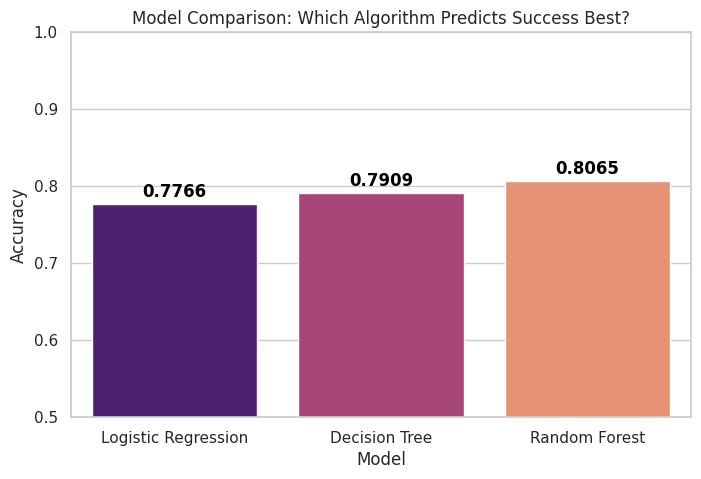

In [21]:
# --- MODEL COMPARISON ---
# Create a DataFrame for comparison
results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest'],
    'Accuracy': [acc_log, acc_dt, acc_rf]
})

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Accuracy', data=results_df, palette='magma')
plt.title("Model Comparison: Which Algorithm Predicts Success Best?")
plt.ylim(0.5, 1.0) 
for index, row in results_df.iterrows():
    plt.text(index, row.Accuracy + 0.01, f"{row.Accuracy:.4f}", ha='center', color='black', weight='bold')
plt.show()

## 8. Detailed Model Evaluation
We begin by looking at the **Global Metrics**.
* **F1-Score (Macro):** This tells us if the model is good at all classes, not just the majority "Medium" class.
* **ROC-AUC:** A score of 1.0 means perfect separation. Anything above 0.80 is considered excellent for human-behavior data.

In [22]:
from sklearn.metrics import f1_score, roc_auc_score, classification_report

# 1. Calculate Advanced Metrics
f1_macro = f1_score(y_test, y_pred_rf, average='macro')
roc_auc = roc_auc_score(y_test, y_prob_rf, multi_class='ovr')

# 2. Print Report
print("MODEL PERFORMANCE REPORT")
print(f"   Accuracy:   {acc_rf:.4f}")
print(f"   F1 (Macro): {f1_macro:.4f} (Measures balance between classes)")
print(f"   ROC-AUC:    {roc_auc:.4f} (Ability to distinguish Hit vs Flop)")
print("-" * 60)
print("Detailed Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Low', 'Medium', 'High']))

MODEL PERFORMANCE REPORT
   Accuracy:   0.8065
   F1 (Macro): 0.6281 (Measures balance between classes)
   ROC-AUC:    0.8918 (Ability to distinguish Hit vs Flop)
------------------------------------------------------------
Detailed Classification Report:
              precision    recall  f1-score   support

         Low       0.74      0.23      0.36       594
      Medium       0.83      0.90      0.87     14036
        High       0.72      0.61      0.66      5370

    accuracy                           0.81     20000
   macro avg       0.76      0.58      0.63     20000
weighted avg       0.80      0.81      0.80     20000



### **A. ROC Curve Analysis**
The **Receiver Operating Characteristic (ROC) Curve** visualizes the trade-off between sensitivity and false alarms.
* **Goal:** We want curves that hug the **top-left corner**.
* **Insight:** The "Area Under Curve" (AUC) for each class tells us how easily the model can identify that specific tier.

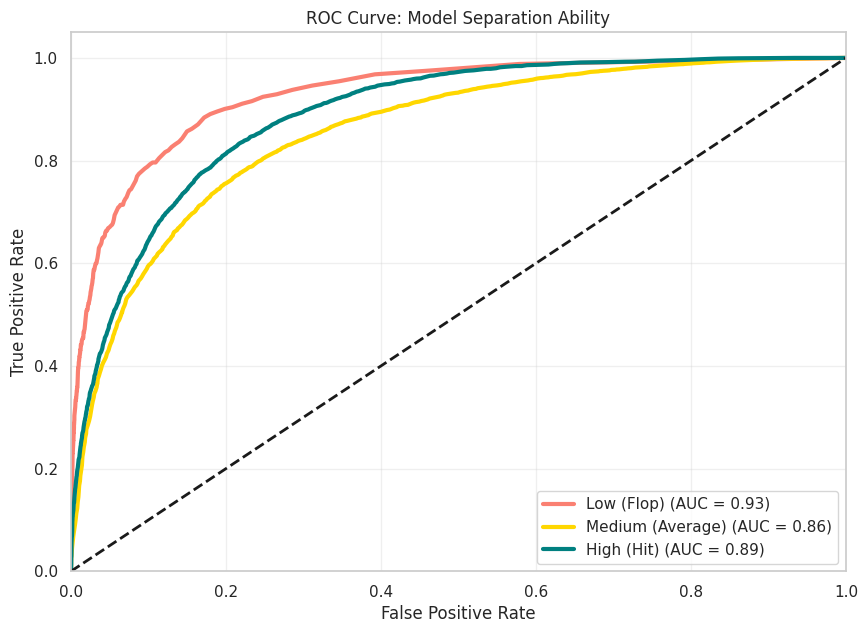

In [23]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# 1. Prepare Data (Binarize the targets)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]
class_names = ['Low (Flop)', 'Medium (Average)', 'High (Hit)']

# 2. Calculate Curves
fpr = dict()
tpr = dict()
roc_auc_val = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob_rf[:, i])
    roc_auc_val[i] = auc(fpr[i], tpr[i])

# 3. Plot
plt.figure(figsize=(10, 7))
colors = ['salmon', 'gold', 'teal']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=3,
             label=f'{class_names[i]} (AUC = {roc_auc_val[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2) # Random Guess Line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Model Separation Ability')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

### **B. Confusion Matrix Analysis**
We use a **Normalized** Confusion Matrix to see the percentage of correct predictions.
* **Critical Check:** Are we accurately predicting the **"Low"** class? (Risk Avoidance)
* **Critical Check:** Are we confusing "Hits" with "Flops"? (Catastrophic Error)

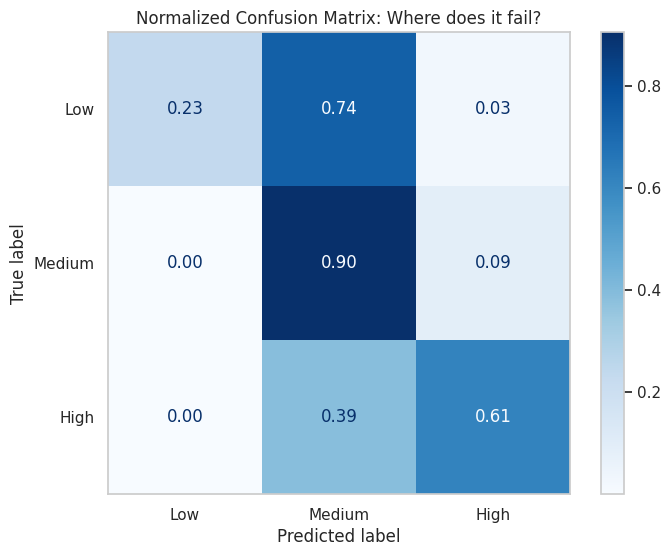

In [24]:
# Normalized Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low', 'Medium', 'High'])

plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', ax=plt.gca(), values_format='.2f')
plt.title("Normalized Confusion Matrix: Where does it fail?")
plt.grid(False)
plt.show()

### **C. Feature Importance (Drivers of Success)**
Finally, we ask the model: *"Which features mattered most?"*
This is the key business insight. It tells us if **Talent** (Director/Cast Score) or **Marketing** (Vote Count) is the stronger driver of a movie's rating.

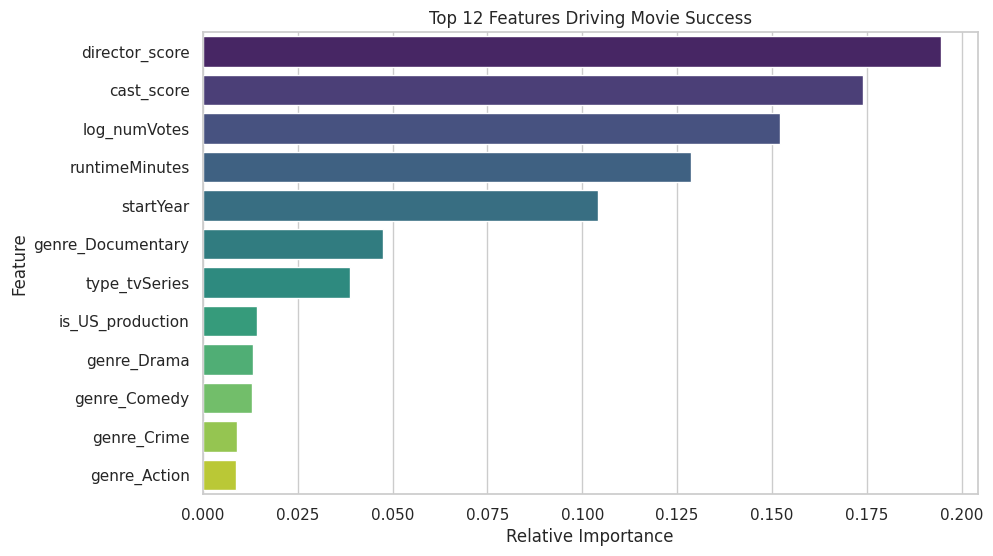

In [25]:
importances = best_rf.feature_importances_
# Use 'X' from the splitting step to get column names
feat_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False).head(12)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_df, palette='viridis')
plt.title("Top 12 Features Driving Movie Success")
plt.xlabel("Relative Importance")
plt.show()

# **Phase 3: Predictive Modeling Summary & Achievements**

* **Objective:** To enhance the predictive accuracy and robustness of our Movie Success Classifier by integrating "Star Power" (human talent) and advanced modeling techniques.
* **Phase 3 Upgrades (vs. Phase 2):**
    * **Data Enrichment:** Integrated `title.crew` and `title.principals` to engineer **Director & Cast Career Scores**.
    * **Leakage Prevention:** Implemented logic to exclude "one-hit wonders" from career averages to ensure valid predictions.
    * **Advanced Evaluation:** Moved beyond simple accuracy to include **ROC-AUC** and **Macro F1-Score**.
* **Model Performance:**
    * **Accuracy:** Achieved **80.65%**, significantly surpassing our **Phase 2 baseline (~74%)**.
    * **Academic Benchmark:** Our result exceeds the **77% benchmark** established in core literature (*Asad et al., 2012*), demonstrating the effectiveness of our enhanced Feature Engineering.
    * **Robustness:** Achieved an **ROC-AUC of 0.89**, indicating excellent separability between "Hits" and "Flops."
* **Key Drivers (Feature Importance) impacting business:**
    * **Talent Investment Strategy:** `director_score` and `cast_score` emerged as the top two strongest predictors, It mathematically validates the industry strategy of "packaging" projects with Top-Tier talent. It proves that a creator's historical track record is the most reliable signal for reducing investment risk, even more so than the genre or budget (proxied by runtime).
    * **Marketing Optimization:** Since `log_numVotes` is the #3 predictor, marketing campaigns are essential for visibility, but they act as a multiplier on top of the talent foundation rather than being the sole driver of perceived quality.